In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
chemin_fichier_excel = "C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\SX5Edec2021.xlsx"

df = pd.read_excel(chemin_fichier_excel, parse_dates=['Dates'])
df = df.rename(columns={'SX5E Index': 'Cours'})

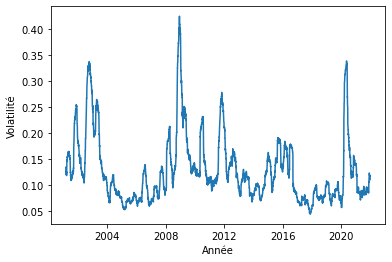

0.12902073604859926


In [4]:
##D'abord on trace les graphiques sans rescaling des données 
#on commence par tracer la vol 60 jours 

df['Volatilite_60jours'] = (df['Cours'].pct_change()*10).rolling(window=60).std()
df['Volatilite_60jours'] = df['Volatilite_60jours']

import matplotlib.pyplot as plt

plt.gcf().clear()

# Tracer la volatilité sur 60 jours
plt.plot(df['Dates'], df['Volatilite_60jours'], label='Volatilité 60 jours')
plt.xlabel('Année')
plt.ylabel('Volatilité')

plt.show()

print(np.mean(df['Volatilite_60jours']))

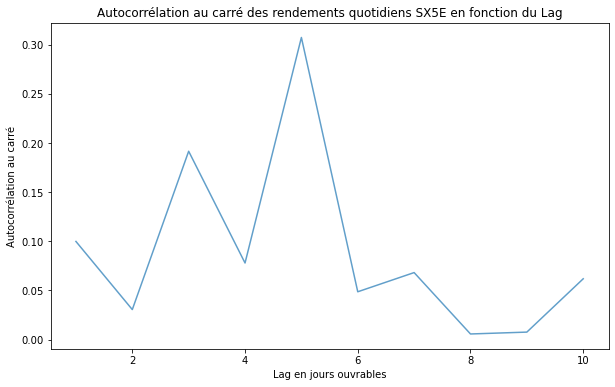

In [5]:
#ensuite on trace l'autocorrélation des rendements au carré

df['Rendements journaliers Xt en %'] = df['Cours'].pct_change()*10

# Calcul d'autocorrélation au carré des rendements quotidiens en fonction du lag
max_lag = 10
autocorr_squared = [(df['Rendements journaliers Xt en %'].autocorr(lag=i)**2) * 100 for i in range(1, max_lag + 1)]


plt.figure(figsize=(10, 6))  


plt.plot(range(1, max_lag + 1), autocorr_squared, marker='', linestyle='-', color='#1f77b4', alpha=0.7)
plt.title('Autocorrélation au carré des rendements quotidiens SX5E en fonction du Lag')
plt.xlabel('Lag en jours ouvrables')
plt.ylabel('Autocorrélation au carré')
plt.grid(False)

plt.show()

0.0008401681047626382 0.14390863727839104


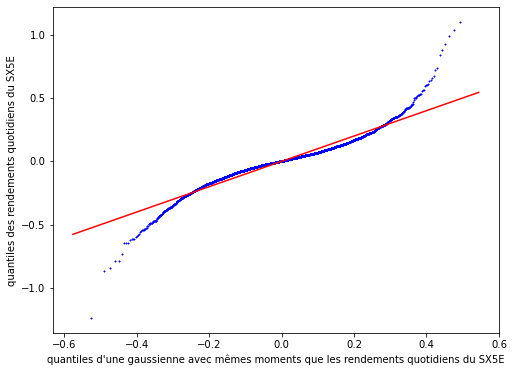

In [6]:
#puis on trace le qq plot des rendements quotidiens du SX5E
#dans le graphe donné en exemple, l'abscisse dit "gaussian quantiles when matching moments of historical daily perf SX5E"
#ça signifie qu'on compare nos quantiles des rdts journaliers du SX5E par rapport aux quantiles d'une distribution théorique 
#de variance mu et sigma? 

from scipy.stats import probplot

#on calcule les moments 
mu = np.mean(df['Rendements journaliers Xt en %'])
sigma = np.std(df['Rendements journaliers Xt en %'])
print(mu,sigma)
fig, ax = plt.subplots(figsize=(8, 6))
probplot(df['Rendements journaliers Xt en %'], dist='norm', sparams=(mu, sigma), plot=ax)
plt.plot(plt.xlim(),plt.xlim(),color='red', label='y=x')
plt.xlabel("quantiles d'une gaussienne avec mêmes moments que les rendements quotidiens du SX5E")
plt.ylabel("quantiles des rendements quotidiens du SX5E")

ax.get_lines()[0].set_marker('+')
ax.get_lines()[0].set_markersize(2)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[0].set_markeredgecolor('blue')

plt.title('')

plt.savefig('C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\graphiques statapp\\qqplot1.png')
#on voit que ça fit mal, en particulier sur la queue. Ca fit + ou - bien sur [-2.5;2.5]

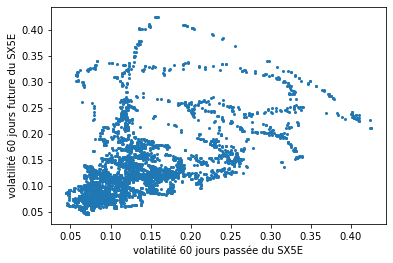

In [7]:
#puis on trace le graphe de vol 60d passés contre vol 60d future

df['rendement journalier futur'] = df['Rendements journaliers Xt en %'].shift(-60) #on décale de 60 jours dans le futur le cours et on re applique la même formule que pour la vol 60 jours passée
df['Volatilite_60jours_future'] = df['rendement journalier futur'].rolling(window=60).std()
df = df.drop(columns=['rendement journalier futur'])

plt.scatter(df['Volatilite_60jours'],df['Volatilite_60jours_future'],s=4,marker='o')
plt.xlabel("volatilité 60 jours passée du SX5E")
plt.ylabel("volatilité 60 jours future du SX5E")
plt.title('')

plt.savefig('C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\graphiques statapp\\volpassé.png')

#on voit que la vol passée permet de prédire la vol future: si on faisait une rég future de vol future sur vol passée, 
#le coeff associé à vol passée n'est clairement pas nul 

In [8]:
#reg linéaire de vol future sur vol passée et significativité du coeff associé 
import statsmodels.api as sm 

x=sm.add_constant(df['Volatilite_60jours'].iloc[60:].iloc[:-60].to_numpy())

y=df['Volatilite_60jours_future'].iloc[60:].iloc[:-60].to_numpy()

modele = sm.OLS(y,x)

resultat=modele.fit()

print(resultat.summary())

# le coefficient est significatif à 1% donc 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     2140.
Date:                Tue, 23 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:02:21   Log-Likelihood:                 7843.0
No. Observations:                5289   AIC:                        -1.568e+04
Df Residuals:                    5287   BIC:                        -1.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0593      0.002     35.286      0.0

In [9]:
print(np.corrcoef(df['Volatilite_60jours'].iloc[60:].iloc[:-60].to_numpy(),y))

[[1.         0.53681325]
 [0.53681325 1.        ]]


NameError: name 'chemin_sauvegarde' is not defined

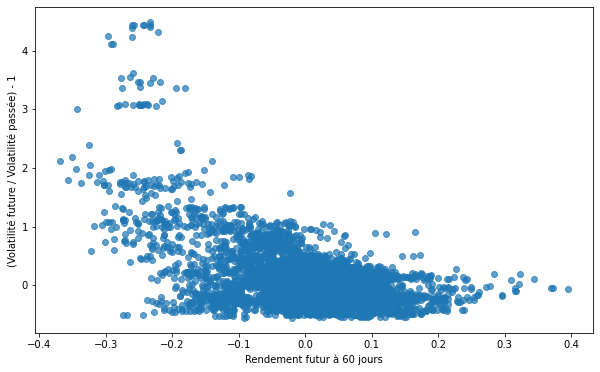

In [10]:
df['performance_future'] = df['Cours'].shift(-60) / df['Cours'] - 1

df['ratio_volatilite'] = (df['Volatilite_60jours_future'] / df['Volatilite_60jours']) - 1

# Création du graphique en nuage de points
plt.figure(figsize=(10, 6))
plt.scatter(df['performance_future'], df['ratio_volatilite'], alpha=0.7)

# Ajout de labels et titre
plt.title('')
plt.xlabel('Rendement futur à 60 jours')
plt.ylabel('(Volatilité future / Volatilité passée) - 1')

#chemin_sauvegarde = 'C:\Users\lecle\Desktop\ENSAE\Graphiques StatApp\graphe_2.png'
plt.savefig(chemin_sauvegarde, dpi=300)

# Affichage du graphique
plt.show()

Coefficient : 0.5371587791484358
Constante : 0.05932246155039726
R² : 0.28816846786807215


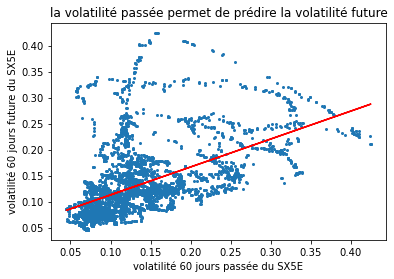

In [11]:
#test de reg linéaire de vol future sur vol passée old 
from sklearn.linear_model import LinearRegression

model = LinearRegression()


x=df['Volatilite_60jours'].iloc[60:].iloc[:-60].to_numpy()
x=x.reshape(-1,1)
y=df['Volatilite_60jours_future'].iloc[60:].iloc[:-60].to_numpy()

model.fit(x,y)

Y_pred = model.predict(x)



# on trace le nuage de point et la droite de reg linéaire 
plt.scatter(x,y,s=4,marker='o')

plt.plot(x, Y_pred, color='red', label='Régression linéaire')


plt.xlabel("volatilité 60 jours passée du SX5E")
plt.ylabel("volatilité 60 jours future du SX5E")
plt.title('la volatilité passée permet de prédire la volatilité future')

print("Coefficient :", model.coef_[0])
print("Constante :", model.intercept_)
print("R² :", model.score(x,y))

